In [1]:
%%bash
if ! python -c "import quairkit" 2>/dev/null; then
    pip install -i https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple quairkit 
fi

if ! command -v pdftotext &> /dev/null; then
    conda install -y -c conda-forge poppler
fi

# Quantum phase estimation

<em style="color:gray;">Copyright (c) 2025 QuAIR team. All Rights Reserved.</em>

In this tutorial, we will introduce the Quantum Phase Estimation (QPE) algorithm and its applications, as well as how to implement it in QuAIRKit. In addition, we will also present a special case of the QPE algorithm – the Quantum Amplitude Estimation (QAE) algorithm.

**Table of Contents**

- [Introduction](#Introduction)
- [Quantum phase estimation algorithm](#quantum-phase-estimation-algorithm)
- [Extension](#extension)
  - [Random input state](#random-input-state)
  - [Quantum amplitude estimation algorithm](#quantum-amplitude-estimation-algorithm)

In [2]:
import torch
import numpy as np
import math

import quairkit as qkit
from quairkit import Circuit, to_state
from quairkit.database import *
from quairkit.qinfo import *
qkit.set_dtype("complex128")

import matplotlib.pyplot as plt
font_family = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = font_family

## Introduction

In quantum mechanics, a unitary operator $U$ often represents the time evolution of a system. When $U$ takes the form $U = e^{iH}$, where $H$ is the Hamiltonian, it characterizes the energy structure of the system. If $|\psi\rangle$ is an eigenstate of $U$, then $U|\psi\rangle = e^{i\theta}|\psi\rangle$, where $e^{i\theta}$ is the corresponding eigenvalue. The parameter $\theta$ is called the eigenphase. Since $U = e^{iH}$, the eigenphase $\theta$ corresponds to an energy eigenvalue of $H$. The goal of the Quantum Phase Estimation (**QPE**) algorithm is to estimate the eigenphase $\theta$ of $U$, given access to $U$ and its eigenstate, thereby obtaining information about the system’s energy spectrum.

Here, we randomly generate a unitary $U$ for the experiment, that is, we need to estimate the eigenphase of $U$.

In [3]:
dim_main = 10
U = random_unitary(1, system_dim=dim_main)

The problem that QPE addresses can be formally stated as follows:

Given a unitary operator $U$ and one of its eigenstates $| \psi\rangle$, satisfying
$U | \psi\rangle = e^{2\pi i x} | \psi\rangle,$
where $x \in [0, 1]$ is the eigenphase corresponding to this eigenvalue, the goal of QPE is to estimate the real number $x$.

Note: In $U|\psi\rangle = e^{i\theta}|\psi\rangle$, since the complex exponential function is $2\pi$-periodic, the eigenphase $\theta$ is not unique. To avoid ambiguity, we define $\theta = 2\pi x$, thereby restricting $x$ to the interval $[0, 1]$. In what follows, we uniformly refer to $x$ as the phase.

Here, we randomly select one 10-dimensional eigenstate of $U$:

In [4]:
eigvals, eigvecs = torch.linalg.eig(U)
idx = torch.randint(0, dim_main, (1,)).item()
eigenvalue = eigvals[idx]
psi = to_state(eigvecs[:, idx], system_dim=dim_main)
print(f"Selected eigenstate |ψ{idx}⟩ as the input state for the subsequent example")

Selected eigenstate |ψ0⟩ as the input state for the subsequent example


QPE takes a unitary operator $U$ and one of its eigenstates $| \psi\rangle$ as input. Using $n$ auxiliary qubits and a total of $2^n$ control-$U$, it outputs an $n$-bit binary approximation $x_1 x_2 \ldots x_n \in \{0,1\}^n$ such that  

$$
U | \psi\rangle = e^{2\pi i x} | \psi\rangle,\tag{1}
$$  

where $x \in [0,1]$ is the eigenphase of $U$ corresponding to $| \psi\rangle$.  

## Quantum phase estimation algorithm

The quantum phase estimation algorithm was first proposed by Alexei Kitaev in 1995, when he introduced the idea of measuring the eigenphase of a unitary operator while studying Abelian stabilizer problems, and proposed a quantum measurement scheme based on eigenstates [1]. Almost simultaneously, Peter Shor used the quantum Fourier transform (QFT) and controlled powers of unitary operations to extract the period of modular exponentiation in his factoring algorithm, which is an instance of QPE [2].  

Subsequently, Cleve, Ekert, Macchiavello, and Mosca systematized the idea of QFT and eigenvalue estimation, developing the standard QPE algorithmic framework familiar today [3]. This framework includes controlled powers $U^{2^j}$, the quantum Fourier transform, and measurement. Since then, QPE has become a fundamental module for many quantum algorithms, such as the Harrow–Hassidim–Lloyd (HHL) algorithm for solving linear systems [4], energy eigenvalue estimation in quantum chemistry [5], and later developments like quantum amplitude estimation (QAE).  

It should be emphasized that **QPE itself does not provide quantum speedup**, because its main computational tasks—the Fourier transform and measurement—are essentially classical-like. The true quantum advantage arises when $U^{2^j}$ can be efficiently implemented using $\operatorname{poly}(n)$ resources. For example, in Shor’s algorithm, control-$U^{2^j}$ represents modular exponentiation, which can be constructed with quantum circuits in polynomial time, thus enabling exponential speedup in extracting the periodic structure. This is the fundamental reason why QPE enables Shor’s algorithm to achieve exponential advantage.  


The algorithm runs on two sets of qudits: the first set is an auxiliary system composed of $n$ qubits, and the second set is the main system composed of a single qudit.

In [5]:
num_ancilla_qubits = 4
cir = Circuit(num_ancilla_qubits + 1, system_dim=[2] * num_ancilla_qubits + [dim_main])

Prepare the input state $| \Psi_0\rangle = | 0\rangle^{\otimes n} | \psi\rangle:$

In [6]:
input_state = nkron(zero_state(num_ancilla_qubits), psi)

**First step:** Apply $H$

We apply the tensor product of $n$ Hadamard gates $H^{\otimes n}$ on the auxiliary system, obtaining the quantum state:

$$
|\Psi_1\rangle = (H^{\otimes n} \otimes I) |\Psi_0\rangle 
= \frac{1}{2^{n/2}} (|0\rangle + |1\rangle)^{\otimes n} |\psi\rangle \tag{2}
= \frac{1}{2^{n/2}} \sum_{j=0}^{2^n - 1} |j\rangle |\psi\rangle.
$$

On the right-hand side, $|j\rangle$ is a shorthand for the tensor product of $n$ qubits: $|j\rangle \coloneqq \bigotimes_{\ell=0}^{n-1} |j_\ell\rangle,$ where $j = \sum_{\ell=0}^{n-1} j_\ell 2^\ell$ is the binary expansion of $j$.

In [7]:
cir.h(list(range(num_ancilla_qubits)))

**Second step:** Apply Controlled-$U$ operations

Define the linear combination of unitaries $U^0, U^1, \ldots, U^{2^n-1}$ as $CU$:

$$
CU = \sum_{k=0}^{2^n - 1} |k\rangle \langle k| \otimes U^k.\tag{3}
$$

 Then we have $CU (|k\rangle \otimes |\psi\rangle) = |k\rangle \otimes \left(U^k |\psi\rangle \right),$ meaning that when the auxiliary system is in the state $|k\rangle$, the corresponding operation $U^k$ is applied to the main system.

Since $U^k |\psi\rangle = e^{2\pi i x k } |\psi\rangle$, applying $CU$ to $|\Psi_1\rangle$ gives:

$$
|\Psi_2\rangle = CU |\Psi_1\rangle = \left( \frac{1}{2^{n/2}} \sum_{k=0}^{2^n - 1} e^{2\pi i x k} |k\rangle \right) \otimes |\psi\rangle.\tag{4}
$$

In [8]:
for k in range(num_ancilla_qubits):
    cir.oracle(U.matrix_power(2**k), [num_ancilla_qubits-k-1, num_ancilla_qubits], control_idx=1, latex_name=r'U^{%d}' % (2 ** k))

**Third step:** Apply the inverse quantum Fourier transform (QFT) $\operatorname{QFT}^{-1}$ on the auxiliary system.

The action of the QFT and its inverse is defined on the standard computational basis as:

$$
\operatorname{QFT}_N | k\rangle = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} e^{\frac{2\pi i}{N} jk} | j\rangle, \quad
\operatorname{QFT}_N^{-1} | k\rangle = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} e^{-\frac{2\pi i}{N} jk} | j\rangle. \tag{5}
$$

Therefore,

$$
| \Psi_3\rangle = (\operatorname{QFT}_{2^n}^{-1} \otimes I) | \Psi_2\rangle = \frac{1}{2^{n/2}} \sum_{k=0}^{2^n - 1} e^{2\pi i x k} \left( \frac{1}{2^{n/2}} \sum_{j=0}^{2^n - 1} e^{-\frac{2\pi i kj}{2^n}} | j\rangle \right) \otimes |\psi\rangle = \frac{1}{2^n} \sum_{j=0}^{2^n - 1} \sum_{k=0}^{2^n - 1} e^{-\frac{2\pi i k}{2^n}(j - 2^n x)} | j\rangle \otimes |\psi\rangle. \tag{6}
$$

In [9]:
qft_inverse = dagger(qft_matrix(num_ancilla_qubits))
cir.oracle(qft_inverse, list(range(num_ancilla_qubits)),  latex_name=r'\operatorname{QFT}_{%d}^{-1}' % (2 ** num_ancilla_qubits))

**Fourth step:** Perform measurement at the end.

Circuit for implementing QPE


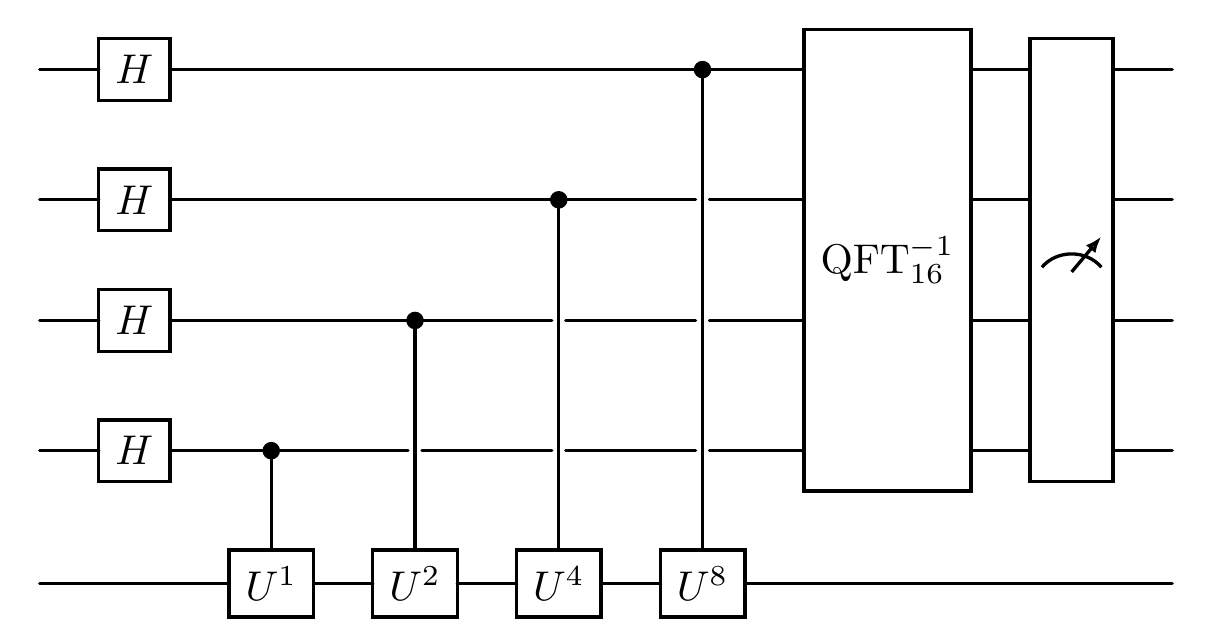

In [10]:
cir.measure(list(range(num_ancilla_qubits)))
print("Circuit for implementing QPE")
cir.plot()

Obtain the measurement result. In the simulator environment, we can directly obtain the probability distribution of possible measurement outcomes.

In [11]:
output_state = cir(input_state)
probs = output_state.probability

Expand the auxiliary system in the computational basis: $| \Psi_3\rangle = \sum_{j=0}^{2^n - 1} c_j | j\rangle,$ where the coefficients are

$$
c_j = \langle j | \Psi_3\rangle = \frac{1}{2^n} \sum_{k=0}^{2^n - 1} e^{-\frac{2\pi i k}{2^n}(j - 2^n x)} 
= \frac{1}{2^n} \sum_{k=0}^{2^n - 1} e^{-2\pi i \frac{k}{2^n}(j - a)} e^{2\pi i \delta k}. \tag{7}
$$

Let $2^n x = a + 2^n \delta$, where $a$ is the integer closest to $2^n x$, and $\delta$ is the fractional part of the difference, satisfying $0 \le |2^n \delta| \le \frac{1}{2}.$

Measure the auxiliary system in the computational basis. The probability of obtaining the outcome $|y\rangle$ is

$$
\Pr(y) = |c_y|^2 = \left| \frac{1}{2^n} \sum_{k=0}^{2^n - 1} e^{-2\pi i \frac{k}{2^n}(y - a)} e^{2\pi i \delta k} \right|^2. \tag{8}
$$

**Theorem.** $\Pr(y)$ achieves its maximum at $y = a$

**Proof.**
Let $N = 2^n$, and define the integer $d = y - a$, then the phase difference is $\theta_d = \delta - \frac{d}{N}$. Thus, $c_y = \frac{1}{2^n} \sum_{k=0}^{N-1} e^{2\pi i k \theta_d},$ which is a geometric series. Using the formula $\sum_{k=0}^{N-1} r^k = \frac{1 - r^N}{1 - r}$ with $r = e^{2\pi i \theta_d}$, we get $|c_y| = \left| \frac{1}{N} \cdot \frac{1 - e^{2\pi i N \theta_d}}{1 - e^{2\pi i \theta_d}} \right|.$ Using the modulus property of complex numbers $|1 - e^{i\alpha}| = 2 |\sin(\alpha / 2)|$, we have $|1 - e^{2\pi i N \theta_d}| = 2 |\sin(\pi N \theta_d)|,  |1 - e^{2\pi i \theta_d}| = 2 |\sin(\pi \theta_d)|.$ Hence, $|c_y| = \frac{1}{N} \cdot \frac{|\sin(\pi N \theta_d)|}{|\sin(\pi \theta_d)|}.$

The probability can be expressed as

$$
\Pr(y) = \frac{1}{N^2} \cdot \frac{\sin^2(\pi \theta_d N)}{\sin^2(\pi \theta_d)},  \theta_d = \delta - \frac{d}{N}. \tag{9}
$$

Denote $\frac{\sin^2(\pi N \theta)}{\sin^2(\pi \theta)} = f(\theta)$, so that $\Pr(y) = \frac{1}{N^2} f(\theta_d).$

The function $f(\theta)$ has the following properties:



- Strictly decreasing on $[0, \frac{1}{2N}]$.  

- For any $\theta \in [\frac{1}{2N}, 0.5)$, we have $f(\theta) = \frac{\sin^2(\pi N \theta)}{\sin^2(\pi \theta)} \le \frac{1}{\sin^2(\pi \theta)} \le \frac{1}{\sin^2(\pi / (2N))} = f\left(\frac{1}{2N}\right),$ because $|\sin(\pi N \theta)| \le 1$ and $\sin(\pi \theta)$ is monotonically increasing on $[0, 0.5]$, so for $\theta \ge \frac{1}{2N}$, we have $\sin(\pi \theta) \ge \sin(\pi / (2N))$. Therefore, on this interval:

$$
f(\theta) \le f\left(\frac{1}{2N}\right). \tag{10}
$$


Since $0 \le |2^n \delta| \le 1/2$, we have $|\delta| \le 1/(2N)$, and $d = y - a$ is an integer:

- If $d = 0$, then $\theta_0 = \delta$, so $|\theta_0| = |\delta| \le 1/(2N)$.  

- If $d \ne 0$, since $|d| \ge 1$, we have $|\theta_d| = \left| \delta - \frac{d}{N} \right| \ge \left| \frac{|d|}{N} - |\delta| \right| \ge \frac{1}{N} - \frac{1}{2N} = \frac{1}{2N}.$
Equality holds only if $|d| = 1$ and $|\delta| = 1/(2N)$.

Hence, $|\theta_d| \ge 1/(2N), |\theta_0| \le 1/(2N), f(|\theta_d|) \le f(1/(2N)) \le f(|\theta_0|) = f(\theta_0).$


Therefore,

$$
\Pr(y) = \frac{1}{N^2} f(\theta_d) \le \frac{1}{N^2} f(\theta_0) = \Pr(a).\tag{11}
$$

Equality occurs only in the boundary case $|d| = 1$ and $|\delta| = 1/(2N)$.

In conclusion, $\Pr(y)$ achieves its maximum at $y = a$ (i.e., $d = 0$).

The probability distribution of outcomes in QPE and the corresponding expected approximated result


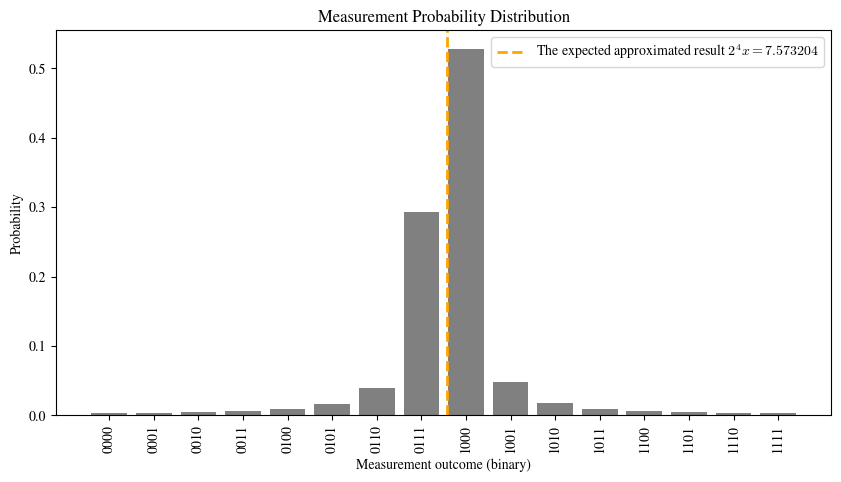

In [12]:
# Compute the eigenphase x from the eigenvalue of psi, where x is expressed in radians
angle_rad = torch.angle(eigenvalue)               
x = (angle_rad / (2 * math.pi)) % 1               
target = 2**num_ancilla_qubits * x                

# Prepare measurement results (0, 1, ..., 2^n - 1)
results = list(range(len(probs)))

plt.figure(figsize=(10, 5))
plt.bar(results, probs, color="gray")
plt.axvline(x=target, color="orange", linestyle="--", linewidth=2,
            label=fr"The expected approximated result $2^{num_ancilla_qubits}x = {target:.6f}$")
bin_labels = [format(r, f'0{num_ancilla_qubits}b') for r in results]
plt.xticks(results, bin_labels, rotation=90)
plt.xlabel("Measurement outcome (binary)")
plt.ylabel("Probability")
plt.title("Measurement Probability Distribution")
plt.legend()
print("The probability distribution of outcomes in QPE and the corresponding expected approximated result")
plt.show()


The horizontal axis represents the measurement outcomes,  which corresponds to the binary representation of the phase, and the vertical axis represents the probability of each outcome. It can be observed that the outcome with the highest probability corresponds to the integer closest to $2^n x$.

## Extension

QPE also has variants and special cases, for example, it can sometimes be performed using only a single ancilla qubit without increasing circuit depth such as the iterative phase estimation algorithm (IPEA) based on the semiclassical quantum Fourier transform [6].
Here we discuss two special cases:

- The input state $| \psi\rangle$ is no longer an eigenstate but a random state.

- The unitary $U$ is the Grover operator used in the quantum amplitude amplification (QAE) algorithm [7] in `week 5 qaa.ipynb`.

### Random input state

In this special case, the problem can be defined as follows: given a unitary operator with the spectral decomposition $U = \sum_j e^{2\pi i x_j} | \psi_j\rangle\langle\psi_j|,$ a random state $| \psi\rangle$ is chosen, which can be expressed as a superposition of the eigenstates $| \psi\rangle = \sum_j c_j | \psi_j\rangle,  c_j \in \mathbb{C}.$ The goal is to use the QPE algorithm to estimate the eigenphases corresponding to multiple eigenstates. 

To better illustrate the randomness, 20 random quantum states are generated here:

In [13]:
batch_state = random_state(1, rank=1, size=20, system_dim=dim_main)
batch_input_state  = nkron(zero_state(num_ancilla_qubits), batch_state)

When $| \psi\rangle$ is a random state, QPE still works because the above derivation is linear. However, the resulting probability distribution becomes more complex, and the probability of obtaining each $x_j$ depends on the magnitude of $c_j$.

In [14]:
batch_measured_state = cir(batch_input_state).trace(list(range(num_ancilla_qubits)))
batch_probs = batch_measured_state.probability

Prepare to plot the results to verify that the outputs match the theoretical expectations:

The average probability distribution of outcomes in QPE and the corresponding expected approximated results


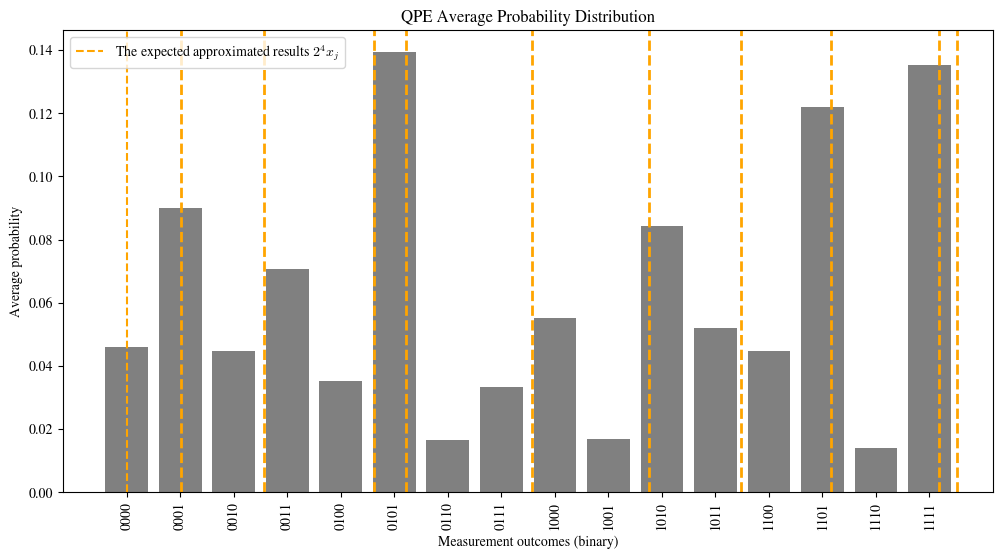

In [15]:
# Compute the phase angles of eigenvalues 
angle_rad = torch.angle(eigvals)                 
x_js = (angle_rad / (2 * math.pi)) % 1          

# Number of possible measurement outcomes
N = 2**num_ancilla_qubits

# Compute the average probability across a batch of measurements
avg_probs = batch_probs.mean(dim=0)
values = avg_probs.tolist()

plt.figure(figsize=(12, 6))
bars = plt.bar(range(N), values, color='gray')
plt.axvline(color='orange', linestyle='--', label=fr"The expected approximated results $2^{num_ancilla_qubits}x_j$")

for x in x_js:
    target = N * x
    plt.axvline(x=target, color='orange', linestyle='--', linewidth=2)
bin_labels = [format(i, f'0{num_ancilla_qubits}b') for i in range(N)]
plt.xticks(range(0, N, max(1, N // 16)), bin_labels[::max(1, N // 16)], rotation=90)
plt.xlabel("Measurement outcomes (binary)")
plt.ylabel("Average probability")
plt.title("QPE Average Probability Distribution")
plt.legend()
print("The average probability distribution of outcomes in QPE and the corresponding expected approximated results")
plt.show()

From the plot, we can see that the outcomes with the highest probabilities correspond roughly to the binary estimates of the eigenphases.

### Quantum amplitude estimation algorithm

According to Oblivious Amplitude Amplification (**OAA**) [8] discussed in the tutorial of quantum amplitude amplification, we can formalize Quantum Amplitude Estimation (**QAE**)  as: given a quantum algorithm or operator $A$ acting on $|0\rangle|\psi\rangle$, it produces

$$A |0\rangle|\psi\rangle = \sin(\theta) |0\rangle V |\psi\rangle + \cos(\theta) |\Psi^\perp\rangle,\tag{12}$$

where $(\langle0| \otimes I) |\Psi^\perp\rangle = 0.$ The goal is to estimate $|\sin(\theta)|$, which is the amplitude of the target state $|0\rangle V |\psi\rangle$. This amplitude corresponds to the probability of obtaining a "good" outcome when measuring the first register. QAE estimates this amplitude using techniques such as QPE without intermediate measurements, allowing more accurate approximate counting or success probability estimation than classical methods. The Grover-like operator $Q = -A S_0 A^\dagger S_0$ with $S_0 = (I - 2 |0\rangle\langle0|) \otimes I$ is regarded as the unitary $U$ that needs to be repeatedly applied in QPE. Here, we adopt an improved variant of the original QAE procedure [7].

First we randomly generate $A$ and $|\psi\rangle$, compute $\theta$, and then construct $Q$:

In [16]:
num_ancilla_qubit = 1
num_main_qubit = 1

A = random_lcu(num_main_qubit, num_ancilla_qubit)
aux_zero = zero_state(num_ancilla_qubit)
psi = random_state(num_main_qubit, rank=1)

In [17]:
dim_total = 2 ** (num_ancilla_qubit + num_main_qubit)
dim_main = 2 ** num_main_qubit

# Compute theta
init_state = nkron(aux_zero, psi)  
final_state = A @ init_state.ket      
proj_0I = nkron(aux_zero.bra, eye(2))               
target_vec = proj_0I @ final_state             # = (⟨0|⊗I) A|0>|psi>
sin_theta = torch.linalg.norm(target_vec).item()  # compute amplitude
theta = np.arcsin(sin_theta)                       

# Construct Grover-like operator Q
S_0 = eye(dim_total) - 2 * nkron(aux_zero.density_matrix, eye(dim_main))  # reflection about |0>
Q = -A @ S_0 @ dagger(A) @ S_0                                   # Grover-like operator


Next, we will show that when the input state is $A |0\rangle|\psi\rangle$, using the QPE algorithm with queries to the controlled-$Q$ operator can output either $+2\theta$ or $-2\theta$, where $|\sin(\theta)|$ is the amplitude we want to estimate.  

First, for simplicity, we introduce several notations: $|\phi_0\rangle = |0\rangle V |\psi\rangle, |\phi_1\rangle = |\Psi^\perp\rangle. $




In the basis $\{ |\phi_0\rangle, |\phi_1\rangle \}$, the matrix representation of the operator $Q$ is: 

$$Q = 
\begin{pmatrix}
\cos(2\theta) & \sin(2\theta) \\
-\sin(2\theta) & \cos(2\theta)
\end{pmatrix}$$

The detailed derivation can be found in the tutorial of quantum amplitude amplification. $Q$ is a rotation matrix, whose characteristic equation is $\det(Q - \lambda I) = (\cos(2\theta) - \lambda)^2 + \sin^2(2\theta) = 0$, giving eigenvalues:  $\lambda_{\pm} = \cos(2\theta) \pm i\sin(2\theta) = e^{\pm i 2\theta}$, with corresponding eigenvectors:  $|w_{\pm}\rangle = \frac{1}{\sqrt{2}} \left( |\phi_0\rangle \pm i |\phi_1\rangle \right)$

In the following, we verified $|w_{\pm}\rangle$ are eigenvectors of $Q$, and the corresponding eigenphases are $\pm 2\theta$ through experiment:


In [18]:
phi0 = proj_0I @ final_state
phi0 = nkron(aux_zero.ket, phi0)        
phi0_full = phi0 / torch.linalg.norm(phi0)

phi1_full = final_state - phi0
phi1_full = phi1_full / torch.linalg.norm(phi1_full)

w_plus  = (phi0_full + 1j * phi1_full) / np.sqrt(2)
w_minus = (phi0_full - 1j * phi1_full) / np.sqrt(2)

eigenvalue_plus  = (dagger(w_plus)  @ Q @ w_plus).item()
eigenvalue_minus = (dagger(w_minus) @ Q @ w_minus).item()

print('Eigenphases of Q with respect to |w±>:', np.angle(eigenvalue_plus), np.angle(eigenvalue_minus))
print('2θ =', 2*theta)

Eigenphases of Q with respect to |w±>: 1.692874813749667 -1.692874813749667
2θ = 1.6928748137496674


Then the input state can be decomposed as: 
\begin{align*}
A |0\rangle|\psi\rangle &= \sin(\theta)|\phi_0\rangle + \cos(\theta)|\phi_1\rangle\\
&= \frac{1}{\sqrt{2}} \left[ (\sin\theta - i \cos\theta) |w_+ + (\sin\theta + i \cos\theta) |w_-\rangle \right] \tag{13}
\end{align*}

The modulus squared of the coefficients:  $\left| \frac{1}{\sqrt{2}} (\sin\theta - i \cos\theta) \right|^2 = \frac{1}{2}$ ,$\left| \frac{1}{\sqrt{2}} (\sin\theta + i \cos\theta) \right|^2 = \frac{1}{2}.$

Thus, the input state is a uniform superposition of the two eigenvectors of $Q$:  $A|0\rangle |\psi\rangle = \frac{1}{\sqrt{2}} \left( e^{-i\eta} |w_+\rangle + e^{i\eta} |w_-\rangle \right),  \eta = \arctan\left( \frac{\sin\theta}{\cos\theta} \right).$

Next, we present the circuit implementation of QAE:

Circuit for implementing QAE


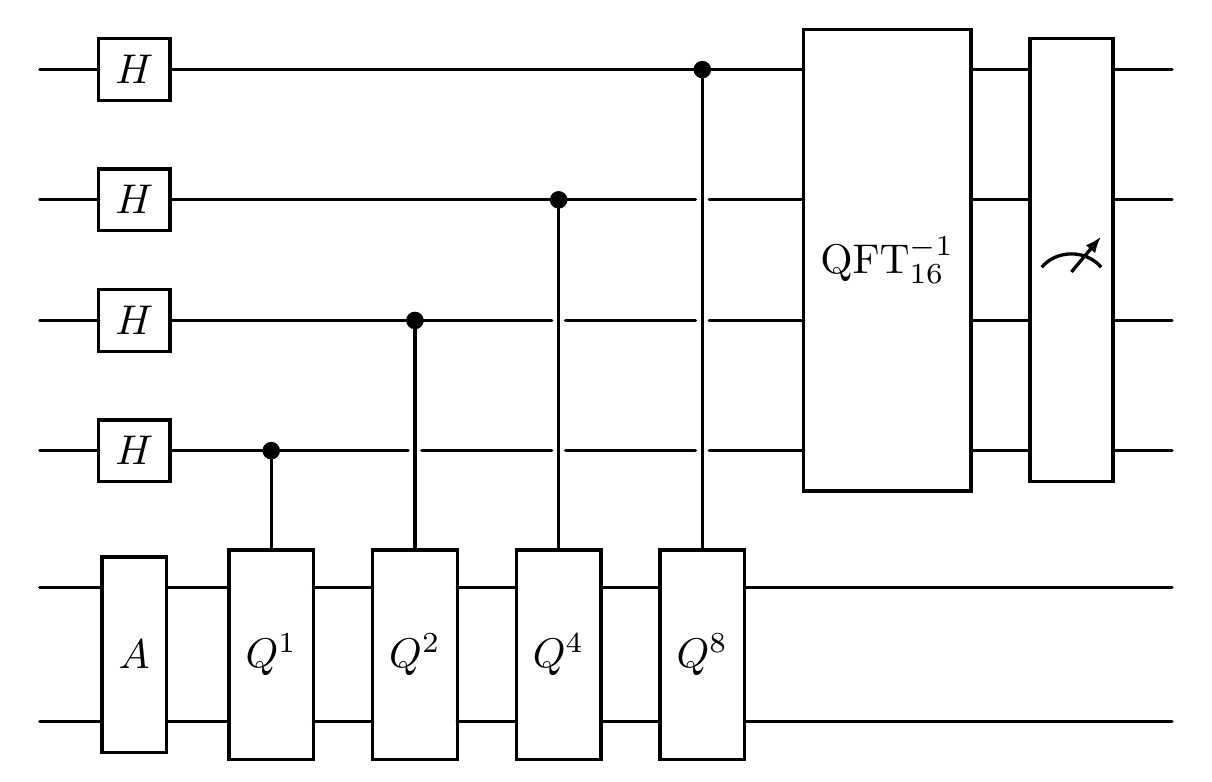

In [19]:
cir = Circuit(num_ancilla_qubits + 2, system_dim=[2] * num_ancilla_qubits + init_state.system_dim)

cir.oracle(A, [4, 5], latex_name=r'A')
cir.h(list(range(num_ancilla_qubits)))

for k in range(num_ancilla_qubits):
    cir.oracle(Q.matrix_power(2**k), [[num_ancilla_qubits - k - 1], 4, 5], control_idx=1, latex_name=r'Q^{%d}' % (2 ** k))

qft_inverse = dagger(qft_matrix(num_ancilla_qubits))
cir.oracle(qft_inverse, list(range(num_ancilla_qubits)), latex_name=r'\operatorname{QFT}_{%d}^{-1}' % (2 ** num_ancilla_qubits))
cir.measure(list(range(num_ancilla_qubits)))
print("Circuit for implementing QAE")
cir.plot()


Next, we present the measurement results and their probability distribution:

In [20]:
input_state = nkron(kron_power(zero_state(1), num_ancilla_qubits), init_state)
output_state = cir(input_state) 

probs = output_state.probability

In the post-processing, we compute $|\sin(\theta)|$ for each QPE measurement result $k$, plot the probability distribution, and highlight the bar corresponding to the true value.

The probability distribution of estimated amplitudes |sin(θ_k)| from QPE measurement and the corresponding true amplitude |sin(θ)|


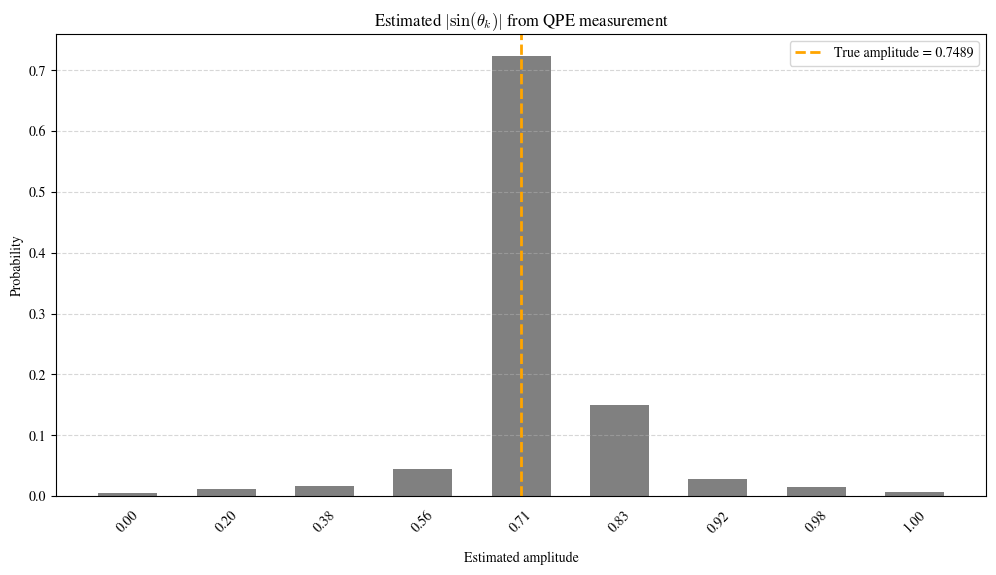

In [21]:
eigvals, eigvecs = torch.linalg.eig(Q)
angle_rad = torch.angle(eigvals)

# Convert the angles to fractional phases x_j in [0, 1)
x_js = (angle_rad / (2 * math.pi)) % 1

N = 2 ** num_ancilla_qubits

# Compute θ_k and the corresponding |sin(θ_k)|
k_vals = torch.arange(N)
theta_k = (math.pi * k_vals) / N
estimated_sin_theta = torch.abs(torch.sin(theta_k))

probs_list = probs.tolist()
rounded_amp = (estimated_sin_theta * 10000).round() / 10000
unique_amplitudes, inverse_indices = torch.unique(rounded_amp, return_inverse=True)

combined_probs = torch.zeros_like(unique_amplitudes)
for idx, p in zip(inverse_indices, probs_list):
    combined_probs[idx] += p

true_amplitude = abs(sin_theta)
true_idx = (torch.abs(unique_amplitudes - true_amplitude)).argmin().item()

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(unique_amplitudes)), combined_probs.tolist(), width=0.6, color='gray', align='center')
for bar, amp in zip(bars, unique_amplitudes):
    plt.text(bar.get_x() + bar.get_width()/2, -0.02,  
             f"{amp.item():.2f}",
             ha='center', va='top', rotation=45, color='black')
plt.axvline(x=true_idx, color='orange', linestyle='--', linewidth=2, label=f'True amplitude = {true_amplitude:.4f}')
plt.title(r'Estimated $|\sin(\theta_k)|$ from QPE measurement')
plt.xlabel('Estimated amplitude', labelpad=40)
plt.ylabel('Probability')
plt.legend()
plt.xticks([])
plt.grid(True, linestyle='--', alpha=0.5)
print("The probability distribution of estimated amplitudes |sin(θ_k)| from QPE measurement and the corresponding true amplitude |sin(θ)|")
plt.show()


Then, we compare the true value with the estimated result:

In [22]:
estimated_amplitude = abs(math.sin((math.pi * true_idx) / N))

print(f"True amplitude = {true_amplitude:.6f}")
print(f"Estimated amplitude = {estimated_amplitude:.6f} with probability {combined_probs[true_idx]:.6f}")
print(f"Absolute Error = {abs(estimated_amplitude - true_amplitude):.6e}")

True amplitude = 0.748924
Estimated amplitude = 0.707107 with probability 0.723444
Absolute Error = 4.181761e-02


---

## References

[1] Kitaev, A. Yu. "Quantum measurements and the Abelian stabilizer problem." arXiv preprint quant-ph/9511026 (1995).

[2] Shor, Peter W. "Polynomial-time algorithms for prime factorization and discrete logarithms on a quantum computer." SIAM review 41.2 (1999): 303-332.

[3] Cleve, Richard, et al. "Quantum algorithms revisited." Proceedings of the Royal Society of London. Series A: Mathematical, Physical and Engineering Sciences  454.1969 (1998): 339-354.

[4] Harrow, Aram W., Avinatan Hassidim, and Seth Lloyd. "Quantum algorithm for linear systems of equations." Physical review letters 103.15 (2009): 150502.

[5] Aspuru-Guzik, Alán, et al. "Simulated quantum computation of molecular energies." Science 309.5741 (2005): 1704-1707.

[6] Dobšíček, Miroslav, et al. "Arbitrary accuracy iterative quantum phase estimation algorithm using a single ancillary qubit: A two-qubit benchmark." Physical Review A—Atomic, Molecular, and Optical Physics 76.3 (2007): 030306.

[7] Brassard, Gilles, et al. "Quantum amplitude amplification and estimation." arXiv preprint quant-ph/0005055 (2000).

[8] Berry, Dominic W., et al. "Exponential improvement in precision for simulating sparse Hamiltonians." Proceedings of the forty-sixth annual ACM symposium on Theory of computing. 2014.




*Table: A reference of notation conventions in this tutorial.*

| Symbol        | Variant          | Description                               |
|:---------------:|:------------------:|-------------------------------------------|
| $U,V,A$ |  | Unitary operator |
| $H$ |  | Hamiltonian |
| $\|\cdot\rangle$ |  | Quantum state |
| $\theta,\eta$ |  | Eigenphase (Unnormalized) |
| $x$ |  | Eigenphase (Normalized) |
| $\| \Psi_0\rangle$ | $\| 0\rangle^{\otimes n} \| \psi\rangle$ | The input state of QPE  |
| $\|j\rangle$ |  $  \bigotimes_{\ell=0}^{n-1} \|j_\ell\rangle$ | $j = \sum_{\ell=0}^{n-1} j_\ell 2^\ell$ is the binary expansion of $j$ | $\| 0\rangle^{\otimes n}  |
| $\| \Psi_1\rangle$ |  | $(H^{\otimes n} \otimes I) \|\Psi_0\rangle$   |
| $CU$ |  | $\sum_{k=0}^{2^n - 1} \|k\rangle \langle k\| \otimes U^k$  |
| $\| \Psi_2\rangle$ |  | $CU \|\Psi_1\rangle$   |
| $\operatorname{QFT}^{-1}$ |  | The inverse of quantum Fourier transform |
| $\| \Psi_3\rangle$ |  | $(\operatorname{QFT}_{2^n}^{-1} \otimes I)\| \Psi_2\rangle$   |
| $\|0\rangle V \|\psi\rangle$ | $\|\phi_0\rangle$ | Good state in QAE   |
| $\|\Psi^\perp\rangle$ | $\|\phi_1\rangle$ | $(\langle0\| \otimes I) \|\Psi^\perp\rangle = 0$   |
| $S0$ | $(I - 2 \|0\rangle\langle0\|) \otimes I $| zero-state reflection operator |
| $A^\dagger$ |  | The conjugate transpose of $A$ |
| $Q$ | $-A S_0 A^\dagger S_0$ | Grover-like operator |
| $det()$ |  | The determinant of a matrix |
| $\lambda$ |  | Eigenvalue |
| $Pr(y)$ |  | The probability of obtaining result $y$ |


In [23]:
qkit.print_info()


---------VERSION---------
quairkit: 0.4.4
torch: 2.8.0+cpu
numpy: 2.2.6
scipy: 1.15.3
matplotlib: 3.10.6
---------SYSTEM---------
Python version: 3.10.18
OS: Windows
OS version: 10.0.26100
---------DEVICE---------
CPU: ARMv8 (64-bit) Family 8 Model 1 Revision 201, Qualcomm Technologies Inc
